https://towardsdatascience.com/a-machine-learning-approach-building-a-hotel-recommendation-engine-6812bfd53f50

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import seaborn as sns

In [127]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

### *Imp* 
How to extract 1% of data

In [95]:
df = pd.read_csv('../expedia-hotel-recommendations/train.csv.gz', sep=',', nrows=241179)
dest = pd.read_csv('destinations.csv.gz')
df.shape

(241179, 24)

In [96]:
# backup of dataframe for future use
df_backup = df.copy()

In [ ]:
# df = df_backup.copy()

In [98]:
df.head(2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1


C:\Users\Sony\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


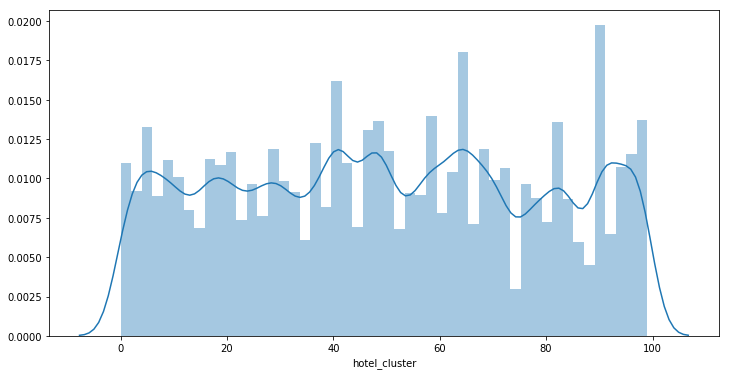

In [99]:
plt.figure(figsize=(12,6))
sns.distplot(df['hotel_cluster'])

In [100]:
from datetime import datetime

def get_year(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass

def get_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass

def left_merge_dataset(left_dataset, right_dataset, merge_columns):
    return pd.merge(left_dataset, right_dataset, on=merge_columns, how='left')

In [101]:
df['date_time_year'] = pd.Series(df.date_time, index= df.index)
df['date_time_month'] = pd.Series(df.date_time, index= df.index)

In [102]:
df.head(1)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,0,3,2,50,628,1,2014-08-11 07:46:59,2014-08-11 07:46:59


In [103]:
df['date_time_year'] = df.date_time_year.apply(lambda x: get_year(x))
df['date_time_month'] = df.date_time_month.apply(lambda x: get_month(x))

In [104]:
df.head(1)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,8250,1,0,3,2,50,628,1,2014,8


In [105]:
df = df.drop('date_time', axis=1)

In [106]:
df[['srch_ci', 'srch_co']].head()

,srch_ci,srch_co
0,2014-08-27,2014-08-31
1,2014-08-29,2014-09-02
2,2014-08-29,2014-09-02
3,2014-11-23,2014-11-28
4,2014-11-23,2014-11-28


In [107]:
df['srch_ci_year'] = df.srch_ci.apply(lambda x: get_year(x))
df['srch_ci_month'] = df.srch_ci.apply(lambda x: get_month(x))

In [108]:
df = df.drop('srch_ci', axis=1)

In [109]:
df['srch_co_year'] = df.srch_co.apply(lambda x: get_year(x))
df['srch_co_month'] = df.srch_co.apply(lambda x: get_month(x))
df = df.drop('srch_co', axis=1)

In [110]:
df.head(2)

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month,srch_ci_year,srch_ci_month,srch_co_year,srch_co_month
0,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,8
1,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,9


In [111]:
df.corr()['hotel_cluster'].sort_values()

srch_destination_type_id    -0.032703
is_booking                  -0.025072
hotel_country               -0.024589
user_location_country       -0.019496
site_name                   -0.017220
srch_destination_id         -0.012454
hotel_continent             -0.010452
srch_rm_cnt                 -0.006863
srch_co_month               -0.001469
user_id                     -0.001451
srch_ci_month               -0.000674
date_time_year              -0.000291
channel                      0.001750
user_location_city           0.001841
is_mobile                    0.002152
date_time_month              0.005345
cnt                          0.005454
srch_adults_cnt              0.008681
posa_continent               0.009592
user_location_region         0.010308
srch_ci_year                 0.010501
srch_co_year                 0.011062
srch_children_cnt            0.013202
orig_destination_distance    0.013668
hotel_market                 0.033555
is_package                   0.049519
hotel_cluste

In [112]:
df.shape

(241179, 27)

In [113]:
pieces = [df.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)

In [114]:
agg.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
8                   50            416          32               1      2
                                               48               1      3
                                               60               1      4
                                               77               1      2
9                   150           2101         75               0      1

In [115]:
agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)

In [116]:
agg.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,8,50,416,32,0.25,0.181818,0.227723
1,8,50,416,48,0.25,0.272727,0.257426
2,8,50,416,60,0.25,0.363636,0.287129
3,8,50,416,77,0.25,0.181818,0.227723
4,9,150,2101,75,NaN,1.000000,1.000000


In [117]:
agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], 
                            columns='hotel_cluster', values='sum_and_cnt').reset_index()

In [118]:
agg_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,8,50,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,150,2101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.884615,NaN,NaN,NaN,NaN,NaN
3,14,27,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16,50,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
df = pd.merge(df, dest, how='left', on='srch_destination_id')
df = pd.merge(df, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])

In [120]:
df.fillna(0, inplace=True)

In [121]:
df.shape

(241179, 276)

In [122]:
df = df.loc[df['is_booking'] == 1]

In [123]:
X = df.drop(['user_id', 'hotel_cluster', 'is_booking'], axis=1)
y = df.hotel_cluster

In [124]:
X.shape, y.shape

((20258, 273), (20258,))

In [126]:
y.nunique()

100

In [128]:
clf = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=273, max_depth=10, random_state=0))
np.mean(cross_val_score(clf, X, y, cv=10))

0.2635832489867882

In [129]:
from sklearn import svm
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='OVO'))
np.mean(cross_val_score(clf, X, y, cv=10))

0.3434528035708353

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
np.mean(cross_val_scoress_val_score(clf, X, y, cv=10))

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(multi_class='ovr'))
np.mean(cross_val_score(clf, X, y, cv=10))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy'))